# Analytical vs FEM Solution for Terzaghi 1D Consolidation

This notebook compares the analytical solution of Terzaghi’s one-dimensional consolidation equation with a numerical solution obtained using the finite element method (FEM) via FEniCSx.  
The objective is to quantify the error between the two approaches when predicting consolidation settlement.


## Problem definition

A single-layer soil profile is considered. The same parameters are used for both the analytical and FEM solutions. All model parameters are define below and are printed for reference.


## Model parameters

The parameters governing the analytical and FEM solutions are displayed below. These include the; layer thickness, applied load, material properties, time discretisation, spatial discretisation, and analytical series truncation.

## Analytical solution

- The analytical solution is evaluated using a truncated Fourier series, with the number of terms defined in the code (`N_terms`).  
- A single-drainage condition is assumed.  
- The formulation follows standard expressions presented in *Craig’s Soil Mechanics*.  
- The initial condition assumes a uniform excess pore pressure distribution with depth due to instantaneous loading. This approach has been used as the analytical solution for this is given.


## Assumptions and scope

- Terzaghi’s consolidation theory is a one-dimensional formulation and considers consolidation only in the vertical (depth) direction.  
- The initial loading is represented as a uniform excess pore pressure distribution.  
- Stress distributions based on 2:1 dispersion or Boussinesq theory are not considered here and are examined separately in another notebook.



## Purpose of comparison

The analytical solution is used as a reference solution to evaluate the accuracy of the FEM based 1D Terzaghi consolidation model implemented in FEniCSx.  
Error measures, including RMSE and normalised \(L^2\) norms, are evaluated over time, with particular attention paid to early-time behaviour where discretisation effects are most pronounced.

# Limitations
- The accuracy of both the analytical and FEM solutions is sensitive to the choice of spatial and discretisation parameters.
- The use of coarse meshes can lead to inaccurate representation of steep pore pressure gradients that develop near the drained boundary at early times. Hence a large error occuring at this stage.
- Early time boundary layers cannot be adequately resolved by using coarse spatial discretisation,. These can result in early settlement and inflated error metrics (e.g. RMSE and normalised \(L^2\) norms).
- Large time steps can further implicate early discrepancies.


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML
import matplotlib.dates as mdates


# set up to allow juypter notebook to use local modulse from src 
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.insert(0, module_path)

from terazaghi_1d.fea_fenicsx import Get_Terazaghi1D_FEA 
from terazaghi_1d.analytical import Get_Terazaghi1d_Analytical


# parameters 
H = 5
num = 100
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 100
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 1000

total_settlement = Mv*P*H

print("\nModel parameters used for analytical and FEM solutions:")
print("--------------------------------------------------------")
print(f"Layer thickness,             = {H:.2f} m")
print(f"Applied surface pressure,    = {P:.2f} kPa")
print(f"Simulation duration,         = {Tx/(60*60*24):.2f} days")
print(f"Number of time steps         = {time_step}")
print(f"Time step size               = {(dt/(60*60*24)):.2f} days")
print(f"Coefficient of consolidation = {Cv:.2e} m^2/s")
print(f"Coefficient of volume comp.  = {Mv:.2e} m^2/kN\n")
print(f"Number of elements (FEM)     = {num}")
print(f"Number of nodes (FEM)        = {nodes}\n")
print(f"Analytical series terms      = {N_terms}\n")
print(f"Dimensionless time factor    = {time_factor:.4f}")
print(f"Total Settlement             = {total_settlement:.4f} m")


[[1.         0.00323904 0.02271382 0.06318007 0.11900719 0.18169011]
 [1.         0.50891802 0.25632863 0.16692682 0.14928176 0.1522957 ]
 [1.         0.67040051 0.42712882 0.28569309 0.2199997  0.2020144 ]
 [1.         0.74589925 0.53513539 0.38892847 0.30697907 0.28107261]
 [1.         0.79159519 0.6104737  0.47514845 0.39337162 0.36623647]]

Model parameters used for analytical and FEM solutions:
--------------------------------------------------------
Layer thickness,             = 5.00 m
Applied surface pressure,    = 100.00 kPa
Simulation duration,         = 365.00 days
Number of time steps         = 100
Time step size               = 3.65 days
Coefficient of consolidation = 2.00e-07 m^2/s
Coefficient of volume comp.  = 5.00e-04 m^2/kN

Number of elements (FEM)     = 100
Number of nodes (FEM)        = 101

Analytical series terms      = 1000

Dimensionless time factor    = 0.0025
Total Settlement             = 0.2500 m


# FEniCSx Solver

In [2]:
# plotting fenicsx data. to note purposely choicen different t or time_step+1 as fenicsx gives t+1 results due to uh ands 
fem_cdata = Get_Terazaghi1D_FEA(H, num, P, Tx, time_step, Cv, 0, True) # 0 as we are using uniform force 
Z = -np.linspace(0, H, num = nodes)
T = np.linspace(0,(Tx/(60*60*24)), num= time_step)
fem_cdata = pd.DataFrame(fem_cdata, columns = Z, index = T)

fem_cdata

,-0.00,-0.05,-0.10,-0.15,-0.20,-0.25,-0.30,-0.35,-0.40,-0.45,...,-4.55,-4.60,-4.65,-4.70,-4.75,-4.80,-4.85,-4.90,-4.95,-5.00
0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3.686869,1.0,0.825425,0.676871,0.555052,0.455157,0.373241,0.306068,0.250984,0.205813,0.168772,...,1.490173e-08,1.238258e-08,1.035254e-08,8.731403e-09,7.455155e-09,6.473379e-09,5.747296e-09,5.248227e-09,4.956459e-09,4.860466e-09
7.373737,1.0,0.902151,0.807161,0.717141,0.633379,0.556539,0.486841,0.424205,0.368345,0.318852,...,1.505102e-07,1.264836e-07,1.069606e-07,9.125088e-08,7.879835e-08,6.916187e-08,6.199986e-08,5.705828e-08,5.416179e-08,5.320759e-08
11.060606,1.0,0.926071,0.853068,0.781845,0.713137,0.647534,0.585478,0.527271,0.473091,0.423007,...,8.017680e-07,6.810510e-07,5.822092e-07,5.021143e-07,4.382267e-07,3.885178e-07,3.514068e-07,3.257126e-07,3.106165e-07,3.056374e-07
14.747475,1.0,0.938276,0.877029,0.816716,0.757764,0.700554,0.645415,0.592618,0.542376,0.494843,...,3.002464e-06,2.576543e-06,2.225348e-06,1.938932e-06,1.709163e-06,1.529501e-06,1.394825e-06,1.301287e-06,1.246215e-06,1.228030e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350.252525,1.0,0.988868,0.977739,0.966615,0.955501,0.944398,0.933310,0.922240,0.911191,0.900165,...,3.071566e-01,3.057305e-01,3.044716e-01,3.033801e-01,3.024562e-01,3.017000e-01,3.011117e-01,3.006914e-01,3.004392e-01,3.003551e-01
353.939394,1.0,0.988942,0.977888,0.966839,0.955799,0.944771,0.933757,0.922761,0.911785,0.900833,...,3.113880e-01,3.099689e-01,3.087161e-01,3.076299e-01,3.067104e-01,3.059579e-01,3.053725e-01,3.049542e-01,3.047032e-01,3.046196e-01
357.626263,1.0,0.989016,0.978036,0.967061,0.956094,0.945140,0.934199,0.923276,0.912374,0.901494,...,3.155982e-01,3.141862e-01,3.129396e-01,3.118587e-01,3.109437e-01,3.101949e-01,3.096123e-01,3.091961e-01,3.089464e-01,3.088631e-01
361.313131,1.0,0.989089,0.978182,0.967280,0.956387,0.945505,0.934637,0.923787,0.912957,0.902149,...,3.197871e-01,3.183821e-01,3.171417e-01,3.160662e-01,3.151558e-01,3.144107e-01,3.138311e-01,3.134169e-01,3.131684e-01,3.130856e-01


# Analytical Solver

In [3]:
# analytical solution plotitng 
analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, time_step, num, Cv, N_terms)
a_T = np.linspace(0, Tx/(60*60*24), time_step, dtype=float)
analytical_cdata = pd.DataFrame(analytical_cdata, columns= -a_Z, index= a_T)

analytical_cdata

,-0.00,-0.05,-0.10,-0.15,-0.20,-0.25,-0.30,-0.35,-0.40,-0.45,...,-4.55,-4.60,-4.65,-4.70,-4.75,-4.80,-4.85,-4.90,-4.95,-5.00
0.000000,1.0,0.020224,0.010129,0.006756,0.005069,0.004057,0.003382,0.002901,0.002540,0.002259,...,3.215174e-04,3.208397e-04,3.202438e-04,3.197288e-04,3.192941e-04,3.189392e-04,3.186636e-04,3.184670e-04,3.183491e-04,3.183098e-04
3.686869,1.0,0.888602,0.779366,0.674326,0.575280,0.483700,0.400663,0.326834,0.262465,0.207433,...,-2.220446e-16,-6.661338e-16,-2.220446e-16,-6.661338e-16,-6.661338e-16,-6.661338e-16,-4.440892e-16,-2.220446e-16,1.110223e-16,0.000000e+00
7.373737,1.0,0.921101,0.842972,0.766360,0.691968,0.620436,0.552325,0.488105,0.428144,0.372705,...,0.000000e+00,-4.440892e-16,-2.220446e-16,-4.440892e-16,-4.440892e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,1.110223e-16,1.110223e-16
11.060606,1.0,0.935544,0.871509,0.808305,0.746328,0.685951,0.627515,0.571327,0.517652,0.466711,...,1.844080e-13,1.004752e-13,5.473400e-14,2.908784e-14,1.565414e-14,7.882583e-15,4.107825e-15,1.998401e-15,1.221245e-15,1.221245e-15
14.747475,1.0,0.944165,0.888602,0.833582,0.779366,0.726202,0.674326,0.623953,0.575280,0.528480,...,1.850026e-10,1.168989e-10,7.353873e-11,4.608536e-11,2.881939e-11,1.806477e-11,1.148570e-11,7.624235e-12,5.610845e-12,4.987677e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350.252525,1.0,0.988903,0.977808,0.966719,0.955639,0.944571,0.933517,0.922481,0.911465,0.900473,...,3.081521e-01,3.067232e-01,3.054616e-01,3.043678e-01,3.034419e-01,3.026841e-01,3.020945e-01,3.016734e-01,3.014206e-01,3.013364e-01
353.939394,1.0,0.988977,0.977956,0.966941,0.955935,0.944941,0.933961,0.922998,0.912056,0.901136,...,3.124015e-01,3.109797e-01,3.097245e-01,3.086362e-01,3.077150e-01,3.069610e-01,3.063744e-01,3.059553e-01,3.057038e-01,3.056200e-01
357.626263,1.0,0.989050,0.978103,0.967161,0.956229,0.945307,0.934400,0.923510,0.912640,0.901793,...,3.166290e-01,3.152145e-01,3.139657e-01,3.128829e-01,3.119663e-01,3.112162e-01,3.106325e-01,3.102156e-01,3.099654e-01,3.098820e-01
361.313131,1.0,0.989123,0.978248,0.967379,0.956519,0.945670,0.934835,0.924017,0.913219,0.902444,...,3.208346e-01,3.194273e-01,3.181850e-01,3.171078e-01,3.161959e-01,3.154496e-01,3.148690e-01,3.144541e-01,3.142052e-01,3.141222e-01


# Computing for Error 

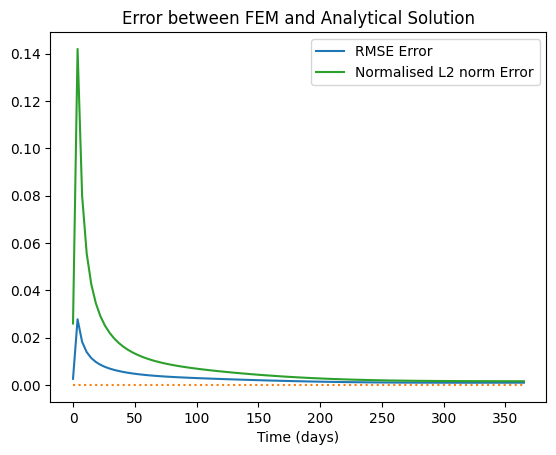

In [4]:
# assumes that the t and z for both data is identical in which it is 
error = fem_cdata - analytical_cdata
#RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))
# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (analytical_cdata**2).sum(axis = 1)
E_L2 = np.sqrt(num / (den+ 1e-12))
time = np.linspace(0, (Tx/(60*60*24)), time_step)


# plotting err
plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot([0,np.max(time)],[0,0], linestyle ="dotted")  # Please change for capture of map
plt.plot(time, E_L2, label = "Normalised L2 norm Error")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Error between FEM and Analytical Solution")
plt.show()


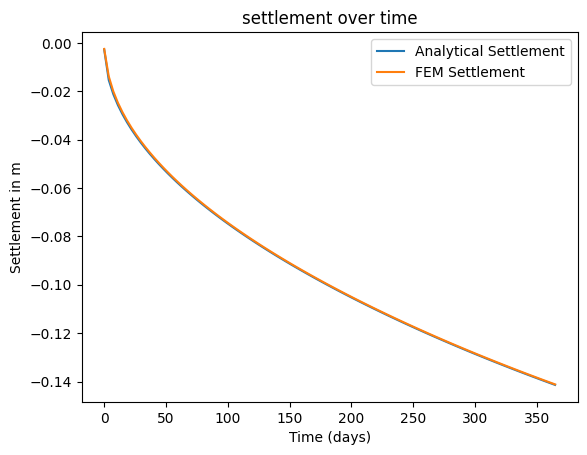

total settlement: 0.25 m
total consolidation settlement reach. 
analytical: 0.1414m 
FEM: 0.1412m 
actual total settlememt: 0.25 


In [5]:

# drawing settlement with time plotting 
analytical_settlement= analytical_cdata.mean(axis=1)*total_settlement
fem_settlement = fem_cdata.mean(axis=1)*total_settlement

plt.figure()
plt.plot(time, -analytical_settlement, label="Analytical Settlement")
plt.plot(time, -fem_settlement, label="FEM Settlement")
plt.xlabel("Time (days)")
plt.ylabel("Settlement in m")
plt.legend()
plt.title("settlement over time")
plt.show()
print(f"total settlement: {total_settlement} m")

print(f"total consolidation settlement reach. \nanalytical: {np.max(analytical_settlement):.4f}m \nFEM: {np.max(fem_settlement):.4}m \nactual total settlememt: {total_settlement:.4} ")

# Heat Map Representation through out time 
note: these use local degree of consolidation and not settlement

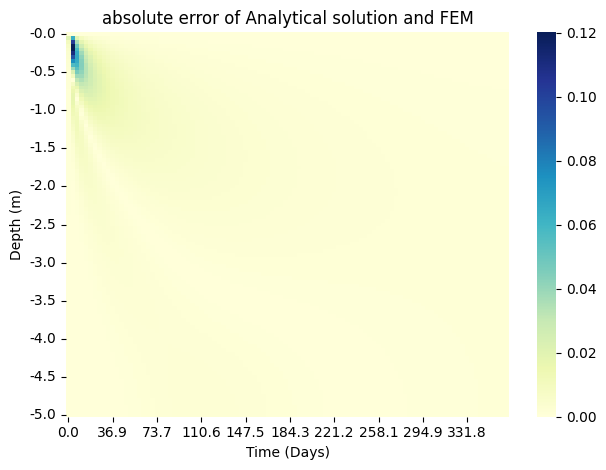

In [6]:
time = time
depth = Z

kx = max(1, len(time)//10)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 


ax = sns.heatmap(abs(error).T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)

ax.set_xlabel("Time (Days)")
ax.set_ylabel("Depth (m)")
ax.set_title("absolute error of Analytical solution and FEM")
plt.tight_layout()
plt.show()
